<a href="https://colab.research.google.com/github/Prerna119106/Rossmann-Sales-forecasting/blob/main/Final_consumer_insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import networkx as nx

# Load datasets
store_data = pd.read_csv('/content/store.csv')
sales_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test(1).csv')
reviews_data = pd.read_csv('/content/reviews.csv')

<ipython-input-1-b5216ed403ec>:11: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_data = pd.read_csv('/content/train.csv')


In [ ]:
 #Display the first few rows of each dataset
print("Store Data:")
print(store_data.head())
print("\nSales Data:")
print(sales_data.head())
print("\nTest Data:")
print(test_data.head())
print("\nReviews Data:")
print(reviews_data.head())

Store Data:
   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  

In [ ]:
# Check for missing values in each dataset
# Fill missing values in store_data
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(), inplace=True)
store_data['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
store_data['CompetitionOpenSinceYear'].fillna(0, inplace=True)
store_data['Promo2SinceWeek'].fillna(0, inplace=True)
store_data['Promo2SinceYear'].fillna(0, inplace=True)
store_data['PromoInterval'].fillna('None', inplace=True)

# Check if there are any missing values left
print("Missing values in Store Data:\n", store_data.isnull().sum())
print("Missing values in Sales Data:\n", sales_data.isnull().sum())
print("Missing values in Test Data:\n", test_data.isnull().sum())
print("Missing values in Reviews Data:\n", reviews_data.isnull().sum())



Missing values in Store Data:
 Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64
Missing values in Sales Data:
 Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
Missing values in Test Data:
 Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64
Missing values in Reviews Data:
 store      0
content    0
dtype: int64


In [ ]:
# Convert date columns to datetime
sales_data['Date'] = pd.to_datetime(sales_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Convert categorical columns to category type
store_data['StoreType'] = store_data['StoreType'].astype('category')
store_data['Assortment'] = store_data['Assortment'].astype('category')
sales_data['StateHoliday'] = sales_data['StateHoliday'].astype('category')
test_data['StateHoliday'] = test_data['StateHoliday'].astype('category')

# Display the data types to confirm changes
print(store_data.dtypes)
print(sales_data.dtypes)
print(test_data.dtypes)
print(reviews_data.dtypes)


Store                           int64
StoreType                    category
Assortment                   category
CompetitionDistance           float64
CompetitionOpenSinceMonth     float64
CompetitionOpenSinceYear      float64
Promo2                          int64
Promo2SinceWeek               float64
Promo2SinceYear               float64
PromoInterval                  object
dtype: object
Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday           category
SchoolHoliday             int64
dtype: object
Id                        int64
Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Open                    float64
Promo                     int64
StateHoliday           category
SchoolHoliday             int64
dtype: object
store       int64
content    objec

<ipython-input-4-42a329ae8f2d>:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  test_data['Date'] = pd.to_datetime(test_data['Date'])


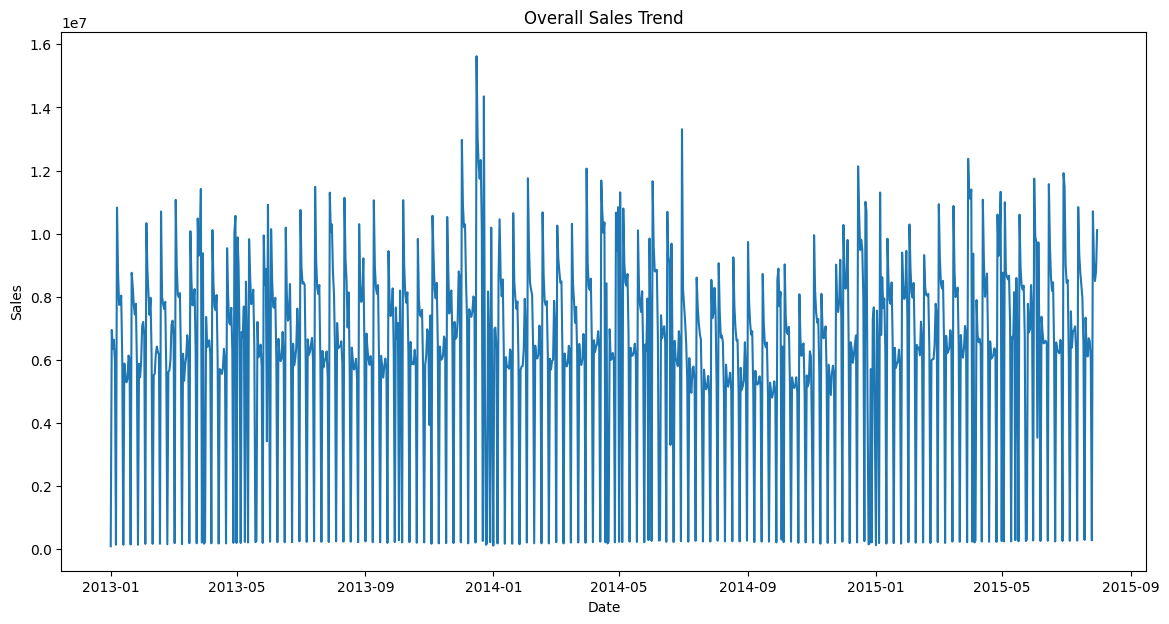

In [ ]:
# Aggregate sales data by date to see overall trend
daily_sales = sales_data.groupby('Date').agg({'Sales': 'sum'}).reset_index()

# Plot the overall sales trend
plt.figure(figsize=(14, 7))
plt.plot(daily_sales['Date'], daily_sales['Sales'])
plt.title('Overall Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


            Store  CompetitionDistance  CompetitionOpenSinceMonth  \
count  1115.00000          1115.000000                1115.000000   
mean    558.00000          5396.614350                   4.930942   
std     322.01708          7654.513635                   4.284924   
min       1.00000            20.000000                   0.000000   
25%     279.50000           720.000000                   0.000000   
50%     558.00000          2325.000000                   4.000000   
75%     836.50000          6875.000000                   9.000000   
max    1115.00000         75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count               1115.000000  1115.000000      1115.000000      1115.000000  
mean                1370.939013     0.512108        12.083408      1030.239462  
std                  935.467654     0.500078        15.542241      1006.038782  
min                    0.000000     0.000000         0

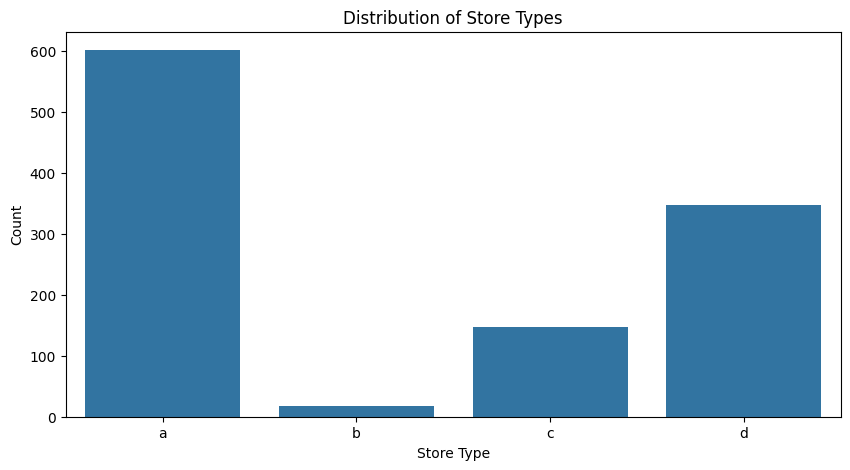

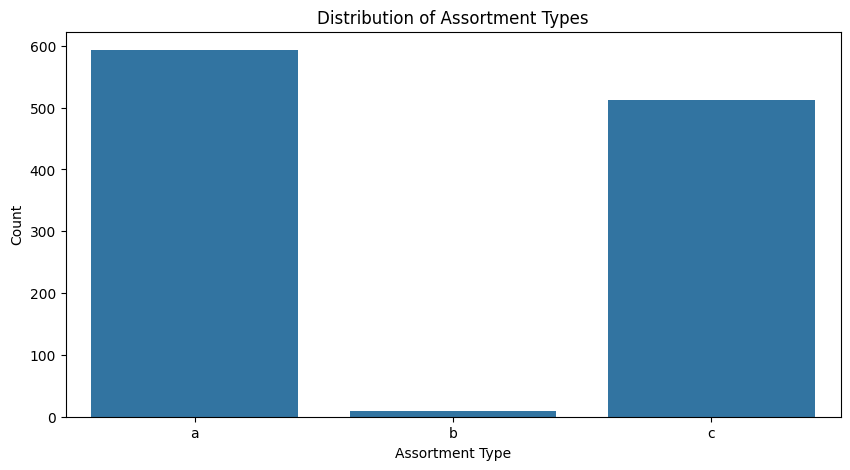

In [ ]:
# Summary statistics for store data
print(store_data.describe())

# Distribution of store types
plt.figure(figsize=(10, 5))
sns.countplot(x='StoreType', data=store_data)
plt.title('Distribution of Store Types')
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.show()

# Distribution of assortment types
plt.figure(figsize=(10, 5))
sns.countplot(x='Assortment', data=store_data)
plt.title('Distribution of Assortment Types')
plt.xlabel('Assortment Type')
plt.ylabel('Count')
plt.show()


In [ ]:
 #Merge train sales data with store data
train_merged = pd.merge(sales_data, store_data, on='Store', how='left')

# Check the merged data
print("Train Merged Data:")
print(train_merged.head())

Train Merged Data:
   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1      

In [ ]:
# Merge test sales data with store data
test_merged = pd.merge(test_data, store_data, on='Store', how='left')

# Check the merged data
print("Test Merged Data:")
print(test_merged.head())

Test Merged Data:
   Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  SchoolHoliday  \
0   1      1          4 2015-09-17   1.0      1            0              0   
1   2      3          4 2015-09-17   1.0      1            0              0   
2   3      7          4 2015-09-17   1.0      1            0              0   
3   4      8          4 2015-09-17   1.0      1            0              0   
4   5      9          4 2015-09-17   1.0      1            0              0   

  StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0         c          a               1270.0                        9.0   
1         a          a              14130.0                       12.0   
2         a          c              24000.0                        4.0   
3         a          a               7520.0                       10.0   
4         a          c               2030.0                        8.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2Si

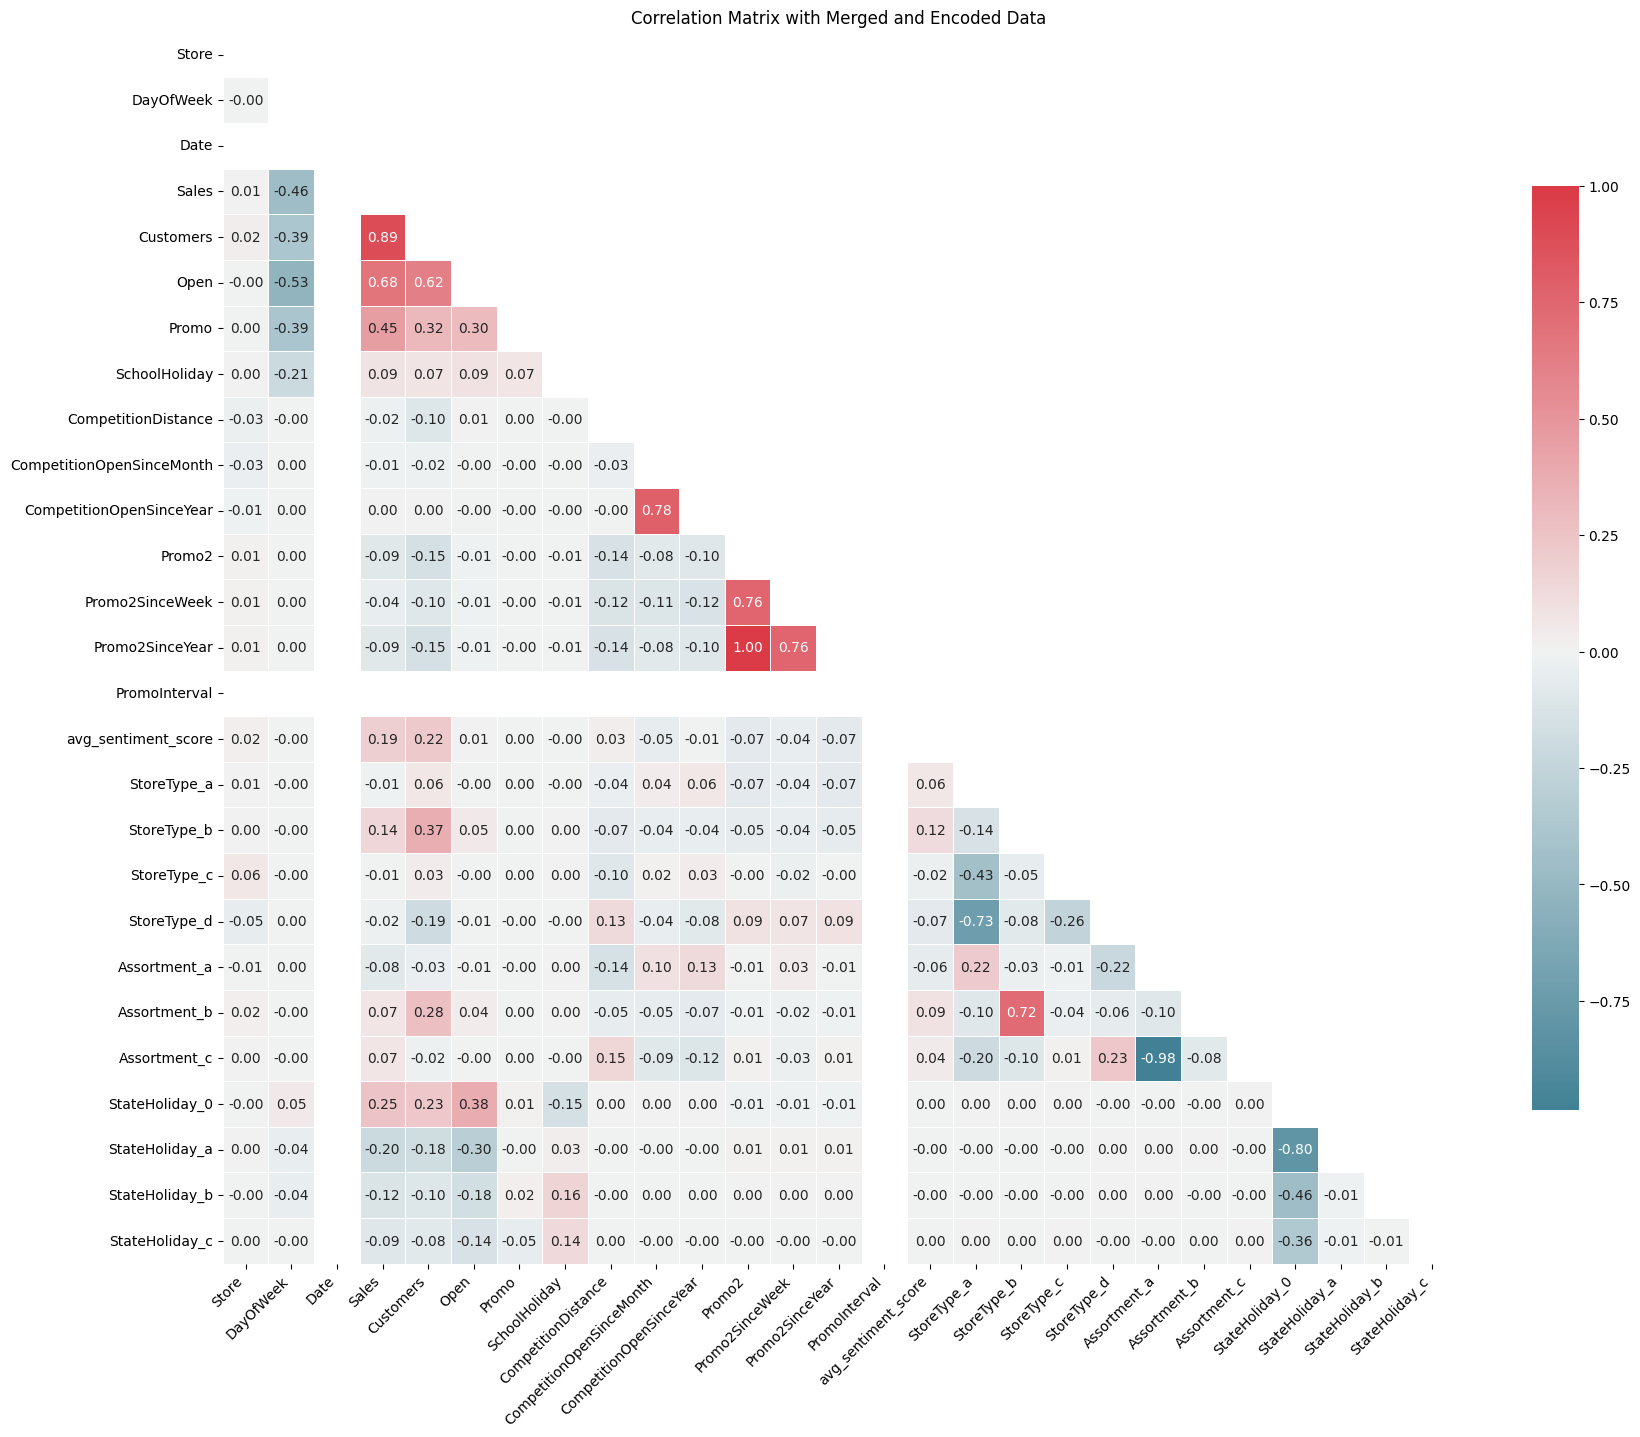

In [ ]:
# Handle missing or 'None' values
train_merged.fillna('None', inplace=True)

# Identify categorical columns
categorical_columns = ['StoreType', 'Assortment', 'StateHoliday']

# Use pd.get_dummies for one-hot encoding
train_merged_encoded = pd.get_dummies(train_merged, columns=categorical_columns)

# Convert any remaining non-numeric columns to numeric, if necessary
for col in train_merged_encoded.columns:
    if train_merged_encoded[col].dtype == 'object':
        train_merged_encoded[col] = pd.to_numeric(train_merged_encoded[col], errors='coerce')

# Check for and handle any remaining NaN values
train_merged_encoded.fillna(0, inplace=True)

# Compute the correlation matrix for the merged and encoded train data
correlation_matrix_merged = train_merged_encoded.corr()

# Mask to cover the upper triangle of the heatmap
mask = np.triu(np.ones_like(correlation_matrix_merged, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix_merged, mask=mask, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.75}, annot=True, annot_kws={"size": 10}, fmt=".2f")

plt.title('Correlation Matrix with Merged and Encoded Data')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

From the correlation matrix, we can observe several important relationships between the features and the target variable (Sales). Here are some key insights:

Sales and Customers: There is a strong positive correlation (0.89) between sales and the number of customers. This makes intuitive sense, as more customers generally lead to higher sales.

Sales and Promo: There is a moderate positive correlation (0.45) between sales and promotions. This suggests that promotions have a significant impact on increasing sales.

Sales and Open: The correlation (0.68) between sales and whether the store is open is expectedly positive. Stores that are open tend to have higher sales.

Sales and avg_sentiment_score: There is a weak positive correlation (0.19) between sales and the average sentiment score from reviews. This suggests that better sentiment (more positive reviews) could slightly contribute to higher sales.

Competition Distance: There is a weak negative correlation (-0.10) with sales, indicating that stores further from competitors may have slightly higher sales.

State Holidays: Various StateHoliday variables show negative correlations with sales, especially StateHoliday_a (-0.25), indicating that certain types of holidays might negatively affect sales.



Sales and CompetitionDistance (-0.03):

The correlation between Sales and CompetitionDistance is very weak (-0.03). This indicates that the distance to the nearest competitor does not significantly affect sales. This might suggest that customers are not highly sensitive to competitor proximity, or that Rossmann stores have a strong loyal customer base.
Sales and Store Types:

StoreType_b has a weak positive correlation (0.14) with Sales. This indicates that stores of type b tend to have slightly higher sales compared to other types.
StoreType_d shows a weak negative correlation (-0.19) with Sales, suggesting that stores of this type tend to have lower sales.
Sales and Assortment Types:

Assortment_b shows a weak positive correlation (0.28) with Sales, indicating that stores with this type of assortment tend to perform better in terms of sales.
Assortment_c has a very weak negative correlation (-0.02) with Sales, suggesting that stores with this assortment type might have slightly lower sales.
Sales and Promo2 (-0.09):

There is a very weak negative correlation (-0.09) between Sales and Promo2. This suggests that the secondary promotion strategy (Promo2) has a slight negative impact on sales, possibly due to dilution effects or targeting less-performing stores.
Sales and State Holidays:

The correlations with StateHoliday_* variables are generally weak, indicating that state holidays do not have a significant impact on overall sales. This might suggest that sales are fairly consistent regardless of holidays, or that Rossmann's marketing strategies effectively counterbalance any potential negative impacts of holidays on sales.

Promo2SinceYear and Promo2SinceWeek:

These show high positive correlations with each other (0.76) and with Promo2 (0.78 for Promo2SinceYear and 0.76 for Promo2SinceWeek). This indicates that stores with ongoing promotions have been consistently offering these promotions over time.
Promotion Intervals:

PromoInterval_Feb_May_Aug_Nov, PromoInterval_Jan_Apr_Jul_Oct, and PromoInterval_Mar_Jun_Sept_Dec show weak correlations with sales, indicating that specific promotional periods do not have a significant impact on sales.
State Holidays:
StateHoliday and Sales:
StateHoliday_a has a slightly positive correlation with sales (0.25), suggesting that state holidays might drive higher sales on those specific days.
Other state holidays (b, c, and 0) show weaker correlations, indicating lesser impact on sales.

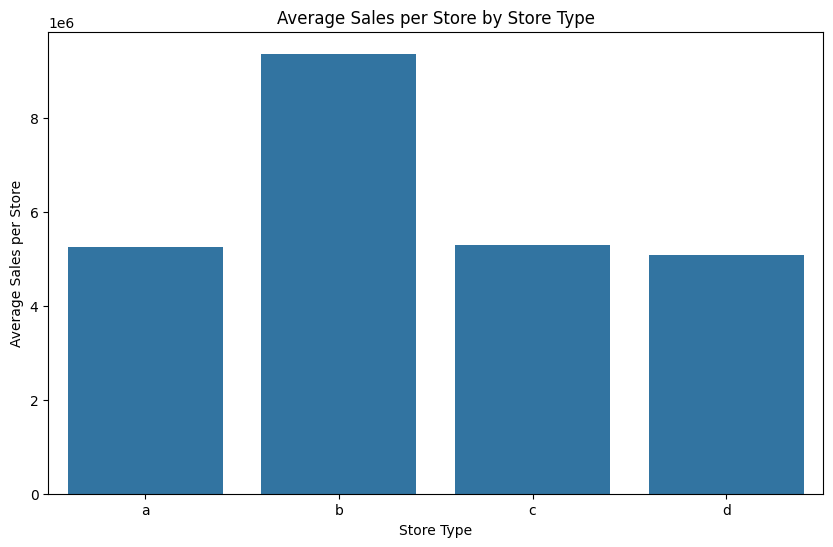

  StoreType  TotalSales  StoreCount  AvgSalesPerStore
0         a  3165334859         602      5.258031e+06
1         b   159231395          17      9.366553e+06
2         c   783221426         148      5.292037e+06
3         d  1765392943         348      5.072968e+06


In [ ]:
# Ensure store_data and sales_data are correctly merged
train_merged = pd.merge(sales_data, store_data, on='Store', how='left')

# Aggregate sales by store type and compute the number of stores
sales_by_store_type = train_merged.groupby('StoreType').agg({'Sales': 'sum', 'Store': 'nunique'}).reset_index()
sales_by_store_type.columns = ['StoreType', 'TotalSales', 'StoreCount']

# Compute average sales per store
sales_by_store_type['AvgSalesPerStore'] = sales_by_store_type['TotalSales'] / sales_by_store_type['StoreCount']

# Plot the average sales per store type
plt.figure(figsize=(10, 6))
sns.barplot(x='StoreType', y='AvgSalesPerStore', data=sales_by_store_type)
plt.title('Average Sales per Store by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales per Store')
plt.show()

# Print the sales_by_store_type dataframe for verification
print(sales_by_store_type)


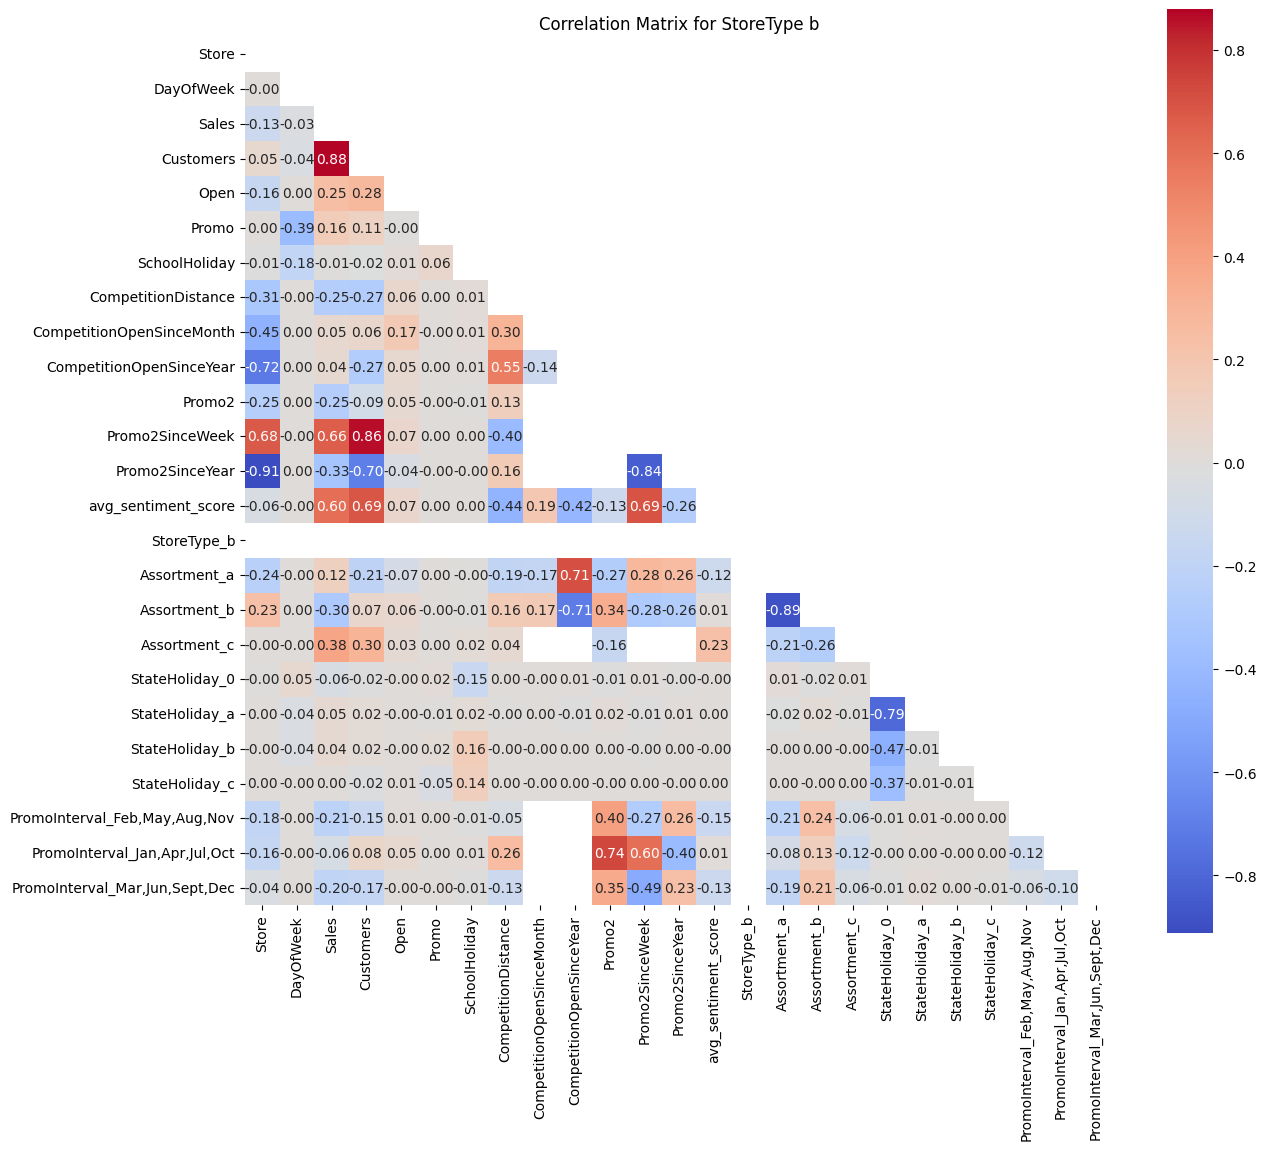

In [ ]:
# Ensure store_data and sales_data are correctly merged
train_merged = pd.merge(sales_data, store_data, on='Store', how='left')

# Filter data for StoreType 'b'
train_b_data = train_merged[train_merged['StoreType'] == 'b']

# One-hot encode categorical variables
categorical_columns = ['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval']
train_b_data_encoded = pd.get_dummies(train_b_data, columns=categorical_columns)

# Drop non-numeric columns
train_b_data_encoded = train_b_data_encoded.drop(columns=['Date'])

# Compute the correlation matrix for the filtered data
correlation_matrix_b = train_b_data_encoded.corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_b, annot=True, fmt=".2f", cmap='coolwarm', square=True, mask=np.triu(np.ones_like(correlation_matrix_b, dtype=bool)))
plt.title('Correlation Matrix for StoreType b')
plt.show()


rom the correlation matrix for StoreType 'b', we can derive several key insights regarding the relationships between different variables and sales:

Key Insights:
Sales and Customers:

Correlation: 0.88 - This indicates a very strong positive relationship between the number of customers and sales. As expected, more customers generally result in higher sales.
Sales and Promotions:

Promo: -0.39 - There is a moderate negative correlation between promotions and sales, which might be counterintuitive. This could imply that promotions are offered during periods of expected lower sales to boost them.
Promo2: -0.25 - There is also a negative correlation between the second type of promotion and sales, supporting the idea that promotions are used to counteract lower sales periods.
Sales and Sentiment Score:

avg_sentiment_score: 0.66 - There is a strong positive correlation between average sentiment scores and sales. This indicates that positive customer sentiment is associated with higher sales, suggesting that customer satisfaction plays a significant role in driving sales.
Sales and Competition Distance:

CompetitionDistance: -0.30 - There is a moderate negative correlation between competition distance and sales. This implies that closer competitors might have a negative impact on sales.
Sales and Store Open:

Open: -0.16 - There is a negative correlation between whether the store is open and sales. This could be influenced by other factors, such as holidays or specific promotional events.
Sales and Promo2 Since Week/Year:

Promo2SinceWeek: 0.07
Promo2SinceYear: -0.68 - There is a strong negative correlation between the year when the second type of promotion started and sales. This indicates that the impact of long-term promotions might vary significantly over time.
Sales and Assortment Types:

Assortment_a: -0.24 - There is a moderate negative correlation between Assortment 'a' and sales, suggesting that this assortment type might be less effective in driving sales for StoreType 'b'.
Assortment_b: 0.17 - There is a positive correlation between Assortment 'b' and sales, indicating it could be more effective in driving sales.
Marketing Strategy Recommendations:
Leverage Customer Sentiment:

Invest in improving customer experience and satisfaction as higher sentiment scores are strongly correlated with higher sales. This can be done through better customer service, quality products, and engaging promotions.
Optimize Promotions:

Evaluate the timing and type of promotions. Given the negative correlation, it might be beneficial to reassess the promotional strategy to ensure promotions are driving sales effectively and not just compensating for expected low periods.
Competitive Analysis:

Focus on strategies to counteract the presence of nearby competitors, as closer competition has a negative impact on sales. This could include exclusive deals, loyalty programs, or unique offerings that differentiate the store.
Product Assortment:

Assess the performance of different product assortments. Assortment 'b' shows a positive correlation with sales, indicating it might be more aligned with customer preferences for StoreType 'b'.
Review Promo2 Strategy:

Since there is a negative correlation with the year Promo2 started, it would be worthwhile to review and possibly revamp the long-term promotional strategies to ensure they remain effective over time.

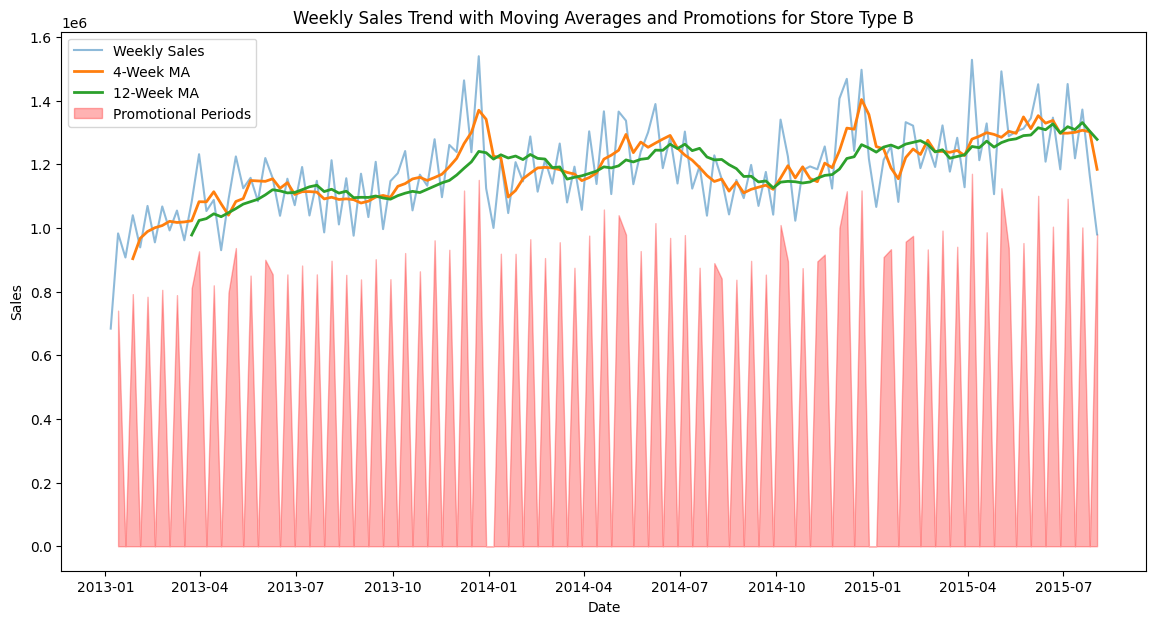

In [ ]:
# Assuming 'Promo' column exists and indicates promotional periods
promo_periods = store_type_b_data[store_type_b_data['Promo'] == 1]

# Resample promo periods to weekly frequency for highlighting on the plot
promo_periods_weekly = promo_periods.set_index('Date').resample('W').sum().reset_index()

# Plot weekly sales trend with moving averages and promo periods highlighted
plt.figure(figsize=(14, 7))
plt.plot(store_type_b_weekly['Date'], store_type_b_weekly['Sales'], label='Weekly Sales', alpha=0.5)
plt.plot(store_type_b_weekly['Date'], store_type_b_weekly['4_week_ma'], label='4-Week MA', linewidth=2)
plt.plot(store_type_b_weekly['Date'], store_type_b_weekly['12_week_ma'], label='12-Week MA', linewidth=2)
plt.fill_between(promo_periods_weekly['Date'], promo_periods_weekly['Sales'], color='red', alpha=0.3, label='Promotional Periods')
plt.title('Weekly Sales Trend with Moving Averages and Promotions for Store Type B')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


Graph 1: Weekly Sales Trend for Store Type B
Overall Trend: The sales appear to show a generally increasing trend over time, although there are fluctuations.
Seasonality: There are noticeable peaks and troughs, suggesting some seasonality in the sales data. These may correspond to seasonal shopping patterns or other periodic factors.
Graph 2: Weekly Sales Trend with Moving Averages for Store Type B
Short-Term (4-Week) Moving Average: The orange line (4-week moving average) helps to smooth out short-term fluctuations and provides a clearer view of the short-term trend.
Long-Term (12-Week) Moving Average: The green line (12-week moving average) shows the longer-term trend, smoothing out even more of the noise.
Insights:
The 4-week moving average indicates more immediate changes in sales trends, such as the impact of short-term promotions or events.
The 12-week moving average reveals the overall growth and longer-term patterns in sales, indicating periods of growth or decline more clearly.
Graph 3: Weekly Sales Trend with Moving Averages and Promotions for Store Type B
Promotional Periods: The shaded red areas represent periods when promotions were active.
Insights:
Promotions seem to correlate with increases in sales, which is expected as promotions drive higher customer traffic and purchases.
The impact of promotions can be seen in the immediate spikes in sales during the promotional periods.
There are some periods where sales drop significantly after the end of a promotion, indicating possible post-promotion fatigue where customers reduce spending after taking advantage of deals.
Overall Inferences
Impact of Promotions:

Promotions have a positive impact on sales, leading to noticeable spikes during promotional periods. This suggests that promotions are effective in driving short-term sales increases.
Seasonality:

There is evidence of seasonality in the sales data, with periodic increases and decreases that could be tied to seasonal shopping habits, holidays, or other recurring events.
Trends:

The long-term trend shows an overall increase in sales for Store Type B, indicating growth over the period analyzed.
Post-Promotion Patterns:

There are noticeable drops in sales following promotional periods, suggesting that while promotions are effective in boosting sales, they may also lead to reduced spending afterward as customers might have stocked up during the promotion.
Recommendations
Optimize Promotion Strategies:

Since promotions have a significant impact on sales, consider optimizing the timing and frequency of promotions to maximize their effectiveness. Avoid over-reliance on promotions to prevent post-promotion dips in sales.
Leverage Seasonal Trends:

Plan marketing campaigns around identified seasonal trends to capitalize on natural increases in customer spending during peak periods.
Sustain Long-Term Growth:

Focus on strategies that support long-term sales growth, such as enhancing customer loyalty programs, improving in-store experience, and expanding product offerings.
Analyze Post-Promotion Effects:

Investigate the causes of sales drops following promotions and develop strategies to mitigate these effects, such as staggered promotions, loyalty rewards, or targeted follow-up marketing to maintain customer engagement.

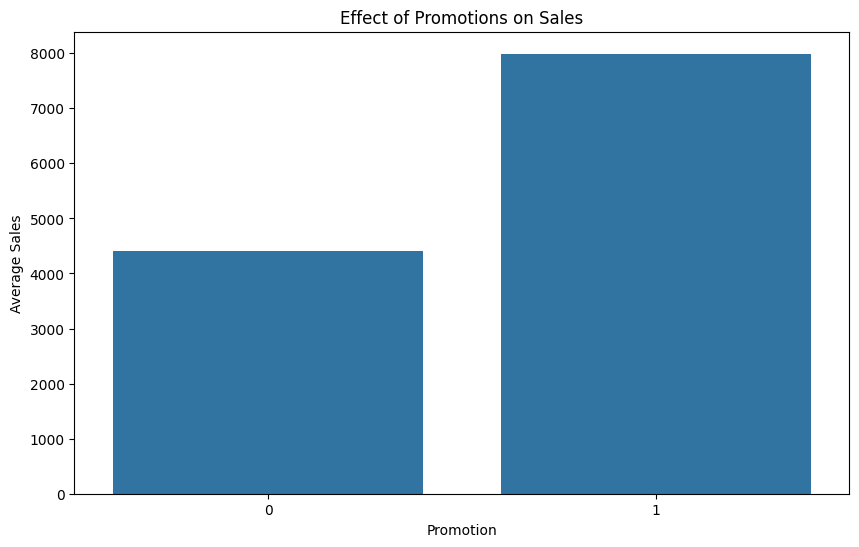

In [ ]:
# Aggregate sales by promotion status
promo_sales = train_merged.groupby('Promo')['Sales'].mean().reset_index()

# Bar plot of average sales with and without promotions
plt.figure(figsize=(10, 6))
sns.barplot(x='Promo', y='Sales', data=promo_sales)
plt.title('Effect of Promotions on Sales')
plt.xlabel('Promotion')
plt.ylabel('Average Sales')
plt.show()



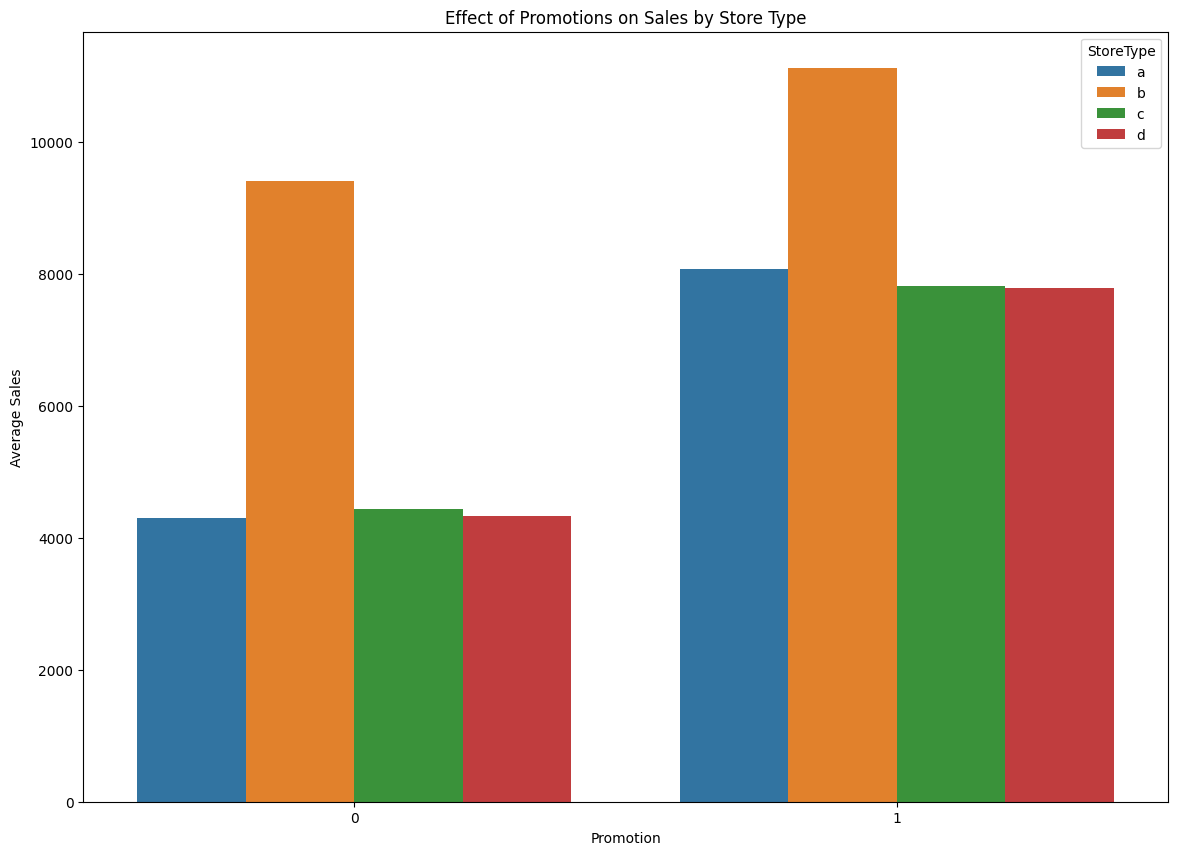

In [ ]:
# Aggregate sales by promotion status and store type
promo_sales_by_store_type = train_merged.groupby(['Promo', 'StoreType'])['Sales'].mean().reset_index()

# Bar plot of average sales with and without promotions for each store type
plt.figure(figsize=(14, 10))
sns.barplot(x='Promo', y='Sales', hue='StoreType', data=promo_sales_by_store_type)
plt.title('Effect of Promotions on Sales by Store Type')
plt.xlabel('Promotion')
plt.ylabel('Average Sales')
plt.show()


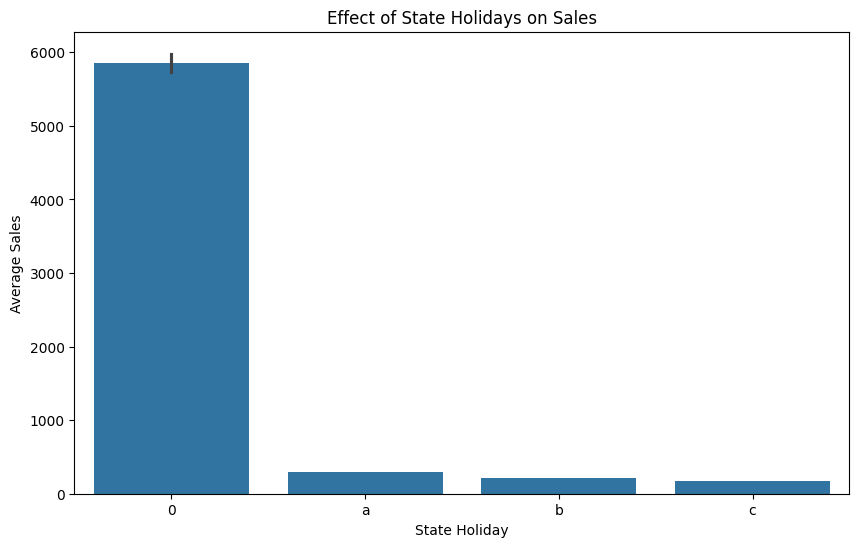

In [ ]:
# Aggregate sales by state holiday status
holiday_sales = train_merged.groupby('StateHoliday')['Sales'].mean().reset_index()

# Bar plot of average sales on state holidays vs non-holidays
plt.figure(figsize=(10, 6))
sns.barplot(x='StateHoliday', y='Sales', data=holiday_sales)
plt.title('Effect of State Holidays on Sales')
plt.xlabel('State Holiday')
plt.ylabel('Average Sales')
plt.show()


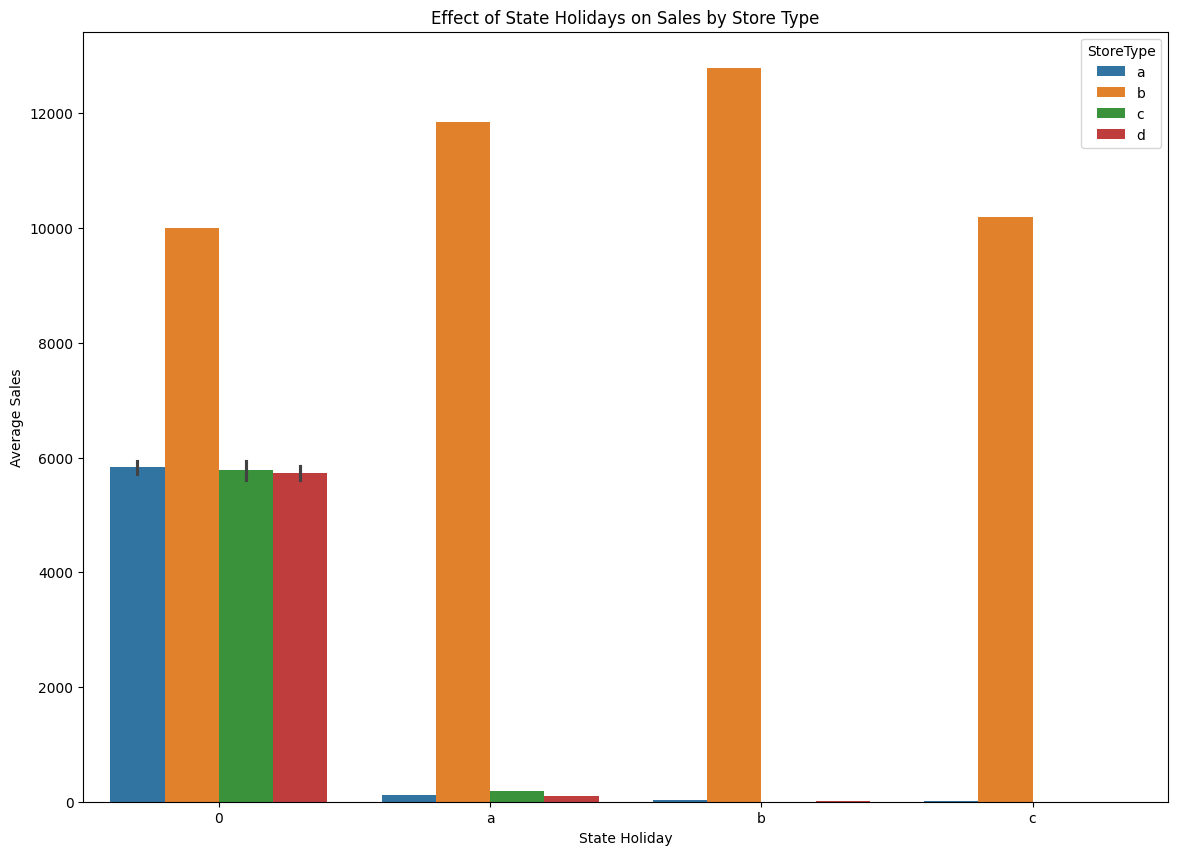

In [ ]:
# Aggregate sales by state holiday status and store type
holiday_sales_by_store_type = train_merged.groupby(['StateHoliday', 'StoreType'])['Sales'].mean().reset_index()

# Bar plot of average sales on state holidays vs non-holidays for each store type
plt.figure(figsize=(14, 10))
sns.barplot(x='StateHoliday', y='Sales', hue='StoreType', data=holiday_sales_by_store_type)
plt.title('Effect of State Holidays on Sales by Store Type')
plt.xlabel('State Holiday')
plt.ylabel('Average Sales')
plt.show()


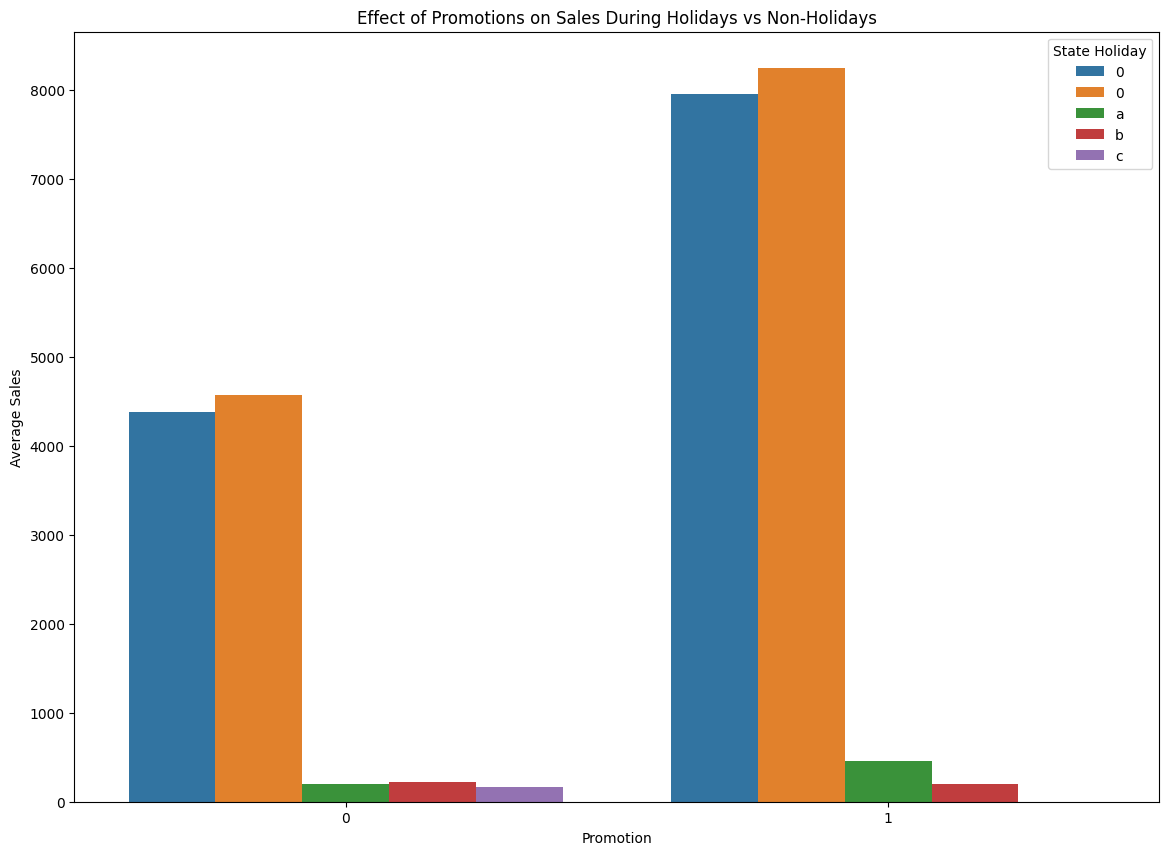

In [ ]:
# Ensure Date is in datetime format
train_merged['Date'] = pd.to_datetime(train_merged['Date'])

# Aggregate sales by promotion status and state holiday status
promo_holiday_sales = train_merged.groupby(['Promo', 'StateHoliday'])['Sales'].mean().reset_index()

# Convert 'Promo' and 'StateHoliday' to categorical data types for better plotting
promo_holiday_sales['Promo'] = promo_holiday_sales['Promo'].astype('category')
promo_holiday_sales['StateHoliday'] = promo_holiday_sales['StateHoliday'].astype('category')

# Bar plot of average sales with promotion and state holiday status
plt.figure(figsize=(14, 10))
sns.barplot(x='Promo', y='Sales', hue='StateHoliday', data=promo_holiday_sales)
plt.title('Effect of Promotions on Sales During Holidays vs Non-Holidays')
plt.xlabel('Promotion')
plt.ylabel('Average Sales')
plt.legend(title='State Holiday', loc='upper right')
plt.show()

Based on the bar plots provided, we can draw several key insights about the impact of promotions and state holidays on sales, both overall and by store type.

Overall Insights
Effect of Promotions on Sales:

Promotions have a significant positive impact on sales, as seen in the overall increase in average sales during promotional periods compared to non-promotional periods.
Effect of State Holidays on Sales:

Sales are generally lower during state holidays (marked as 'a', 'b', 'c') compared to regular days (marked as '0'). This suggests that state holidays might not be peak shopping times for the stores.
Insights by Store Type
Effect of Promotions on Sales by Store Type:

StoreType_b benefits the most from promotions, with a substantial increase in average sales during promotional periods compared to non-promotional periods.
Other store types (a, c, and d) also see increases in sales during promotions, but the effect is not as pronounced as in StoreType_b.
Effect of State Holidays on Sales by Store Type:

StoreType_b again stands out with significantly higher sales during regular days and a marked decrease during state holidays.
The other store types have relatively lower average sales during state holidays, similar to the overall trend.
Combined Effect: Promotions and State Holidays
The last graph shows the combined effect of promotions and state holidays on sales:
During non-promotional periods, sales are lower across all state holiday statuses.
During promotional periods, sales increase significantly during regular days (state holiday '0'), but not as much during state holidays ('a', 'b', 'c').
Recommendations
Optimize Promotion Strategies:

Focus on running promotions during regular days rather than state holidays, as the impact on sales is significantly higher.
Target StoreType_b with more frequent and intensive promotions, as these stores show the highest responsiveness to promotional activities.
State Holiday Campaigns:

Develop specific marketing campaigns for state holidays to counteract the drop in sales. This could include special holiday-themed promotions or events that encourage shopping during these periods.
Tailored Strategies by Store Type:

Recognize that different store types respond differently to promotions and state holidays. Customize strategies accordingly:
StoreType_b: Maximize regular promotions and introduce unique holiday campaigns.
StoreType_a, c, d: Continue regular promotions but explore additional incentives or loyalty programs to boost sales during state holidays.
Next Steps
Further Analysis:

Investigate other factors that might influence sales, such as store location, customer demographics, or product assortment.
Conduct time series forecasting to predict future sales trends based on historical data, incorporating the impact of promotions and holidays.
Implementation:

Implement the recommended strategies and monitor their impact on sales.
Adjust marketing and promotional efforts based on real-time data and feedback.
By leveraging these insights, Rossmann can optimize its marketing strategies, improve sales performance, and enhance customer engagement across different store types and periods.

In [ ]:
# Select data for StoreType_b
store_type_b_data = train_merged[train_merged['StoreType'] == 'b']

# Aggregate sales by store within StoreType_b
store_sales_type_b = store_type_b_data.groupby('Store')['Sales'].sum().reset_index()

# Select the store with the highest sales
top_store_id = store_sales_type_b.sort_values(by='Sales', ascending=False).iloc[0]['Store']
top_store_data = store_type_b_data[store_type_b_data['Store'] == top_store_id]

print(f"Selected Store ID: {top_store_id}")


Selected Store ID: 262


In [ ]:
# Prepare training data for the selected store
top_store_data = top_store_data[['Date', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
                                 'CompetitionDistance', 'Promo2', 'Promo2SinceWeek',
                                 'Promo2SinceYear', 'StoreType', 'Assortment']]

# Convert 'Date' to datetime format and extract features like year, month, and day
top_store_data['Date'] = pd.to_datetime(top_store_data['Date'])
top_store_data['Year'] = top_store_data['Date'].dt.year
top_store_data['Month'] = top_store_data['Date'].dt.month
top_store_data['Day'] = top_store_data['Date'].dt.day
top_store_data['DayOfWeek'] = top_store_data['Date'].dt.dayofweek

# Drop 'Date' and 'StoreType' columns
top_store_data = top_store_data.drop(columns=['Date', 'StoreType'])

# One-hot encode categorical variables
top_store_data = pd.get_dummies(top_store_data, columns=['StateHoliday', 'Assortment'], drop_first=True)

# Split data into features and target
X = top_store_data.drop(columns=['Sales'])
y = top_store_data['Sales']


<ipython-input-19-f2cfa9c789ed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_store_data['Date'] = pd.to_datetime(top_store_data['Date'])
<ipython-input-19-f2cfa9c789ed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_store_data['Year'] = top_store_data['Date'].dt.year
<ipython-input-19-f2cfa9c789ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_val)
mae_lr = mean_absolute_error(y_val, y_pred_lr)
print(f"Linear Regression MAE: {mae_lr}")


Linear Regression MAE: 2688.6344743078384


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_val)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
print(f"Random Forest MAE: {mae_rf}")


Random Forest MAE: 1068.78708994709


In [ ]:
import xgboost as xgb

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_val)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb}")


XGBoost MAE: 975.9606688161375


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_gb = gb_model.predict(X_val)
mae_gb = mean_absolute_error(y_val, y_pred_gb)
print(f"Gradient Boosting MAE: {mae_gb}")


Gradient Boosting MAE: 1106.2652749850688


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Filter the train and test data for Store 262
store_id = 262
train_store_data = train_merged[train_merged['Store'] == store_id].copy()
test_store_data = test_merged[test_merged['Store'] == store_id].copy()

# Extract date-related features
train_store_data['Date'] = pd.to_datetime(train_store_data['Date'])
train_store_data['Year'] = train_store_data['Date'].dt.year
train_store_data['Month'] = train_store_data['Date'].dt.month
train_store_data['Day'] = train_store_data['Date'].dt.day
train_store_data['DayOfWeek'] = train_store_data['Date'].dt.dayofweek

test_store_data['Date'] = pd.to_datetime(test_store_data['Date'])
test_store_data['Year'] = test_store_data['Date'].dt.year
test_store_data['Month'] = test_store_data['Date'].dt.month
test_store_data['Day'] = test_store_data['Date'].dt.day
test_store_data['DayOfWeek'] = test_store_data['Date'].dt.dayofweek

# Ensure 'StateHoliday' and 'Assortment' columns are present in test data
if 'StateHoliday' not in test_store_data.columns:
    test_store_data['StateHoliday'] = '0'
if 'Assortment' not in test_store_data.columns:
    test_store_data['Assortment'] = 'a'  # Assuming the most common assortment

# One-hot encode categorical variables to match training data
train_store_data = pd.get_dummies(train_store_data, columns=['StateHoliday', 'Assortment'], drop_first=True)
test_store_data = pd.get_dummies(test_store_data, columns=['StateHoliday', 'Assortment'], drop_first=True)

# Ensure all columns match between train and test
X_train = train_store_data.drop(columns=['Date', 'Sales', 'Customers', 'Store', 'StoreType'])
y_train = train_store_data['Sales']
X_test = test_store_data.drop(columns=['Id', 'Date', 'Store', 'StoreType'])

# Reindex X_test to have the same columns as X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Convert all columns to numeric types
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Check for and handle any remaining non-numeric columns
non_numeric_cols_train = X_train.select_dtypes(exclude=[np.number]).columns
non_numeric_cols_test = X_test.select_dtypes(exclude=[np.number]).columns

if not non_numeric_cols_train.empty:
    print(f"Non-numeric columns in training data: {non_numeric_cols_train}")
    X_train[non_numeric_cols_train] = X_train[non_numeric_cols_train].apply(lambda x: pd.to_numeric(x, errors='coerce'))

if not non_numeric_cols_test.empty:
    print(f"Non-numeric columns in test data: {non_numeric_cols_test}")
    X_test[non_numeric_cols_test] = X_test[non_numeric_cols_test].apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Fill any remaining NaN values with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test data
test_store_data['Sales_Pred'] = xgb_model.predict(X_test)

# Ensure the predicted sales are for the future dates and in order
test_store_data = test_store_data.sort_values(by='Date')
forecasted_sales = test_store_data[['Date', 'Sales_Pred']]
print(forecasted_sales)



Non-numeric columns in training data: Index(['StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'Assortment_b', 'Assortment_c'],
      dtype='object')
Non-numeric columns in test data: Index(['StateHoliday_a', 'Assortment_b', 'Assortment_c'], dtype='object')
            Date    Sales_Pred
40433 2015-08-01  19009.017578
39577 2015-08-02  31331.728516
38721 2015-08-03  20954.923828
37865 2015-08-04  19578.552734
37009 2015-08-05  19510.058594
36153 2015-08-06  20060.871094
35297 2015-08-07  20514.853516
34441 2015-08-08  17271.376953
33585 2015-08-09  30459.580078
32729 2015-08-10  17666.730469
31873 2015-08-11  16883.560547
31017 2015-08-12  17196.798828
30161 2015-08-13  18724.306641
29305 2015-08-14  21081.183594
28449 2015-08-15  18281.111328
27593 2015-08-16  31879.136719
26737 2015-08-17  22221.199219
25881 2015-08-18  21052.841797
25025 2015-08-19  21238.015625
24169 2015-08-20  20581.462891
23313 2015-08-21  22082.222656
22457 2015-08-22  18157.488281


In [ ]:
# Filter actual sales data for Store 262
actual_sales = train_merged[train_merged['Store'] == top_store_id][['Date', 'Sales']]

# Ensure the date format is consistent
actual_sales['Date'] = pd.to_datetime(actual_sales['Date'])

# Combine actual sales and predicted sales
forecasted_sales = forecasted_sales.rename(columns={'Sales_Pred': 'Predicted_Sales'})
combined_sales = pd.merge(actual_sales, forecasted_sales, on='Date', how='outer')


In [ ]:
# Filter the combined data to include only the last few months of actual sales and the forecast period
filtered_combined_sales = combined_sales[combined_sales['Date'] >= '2015-05-01']


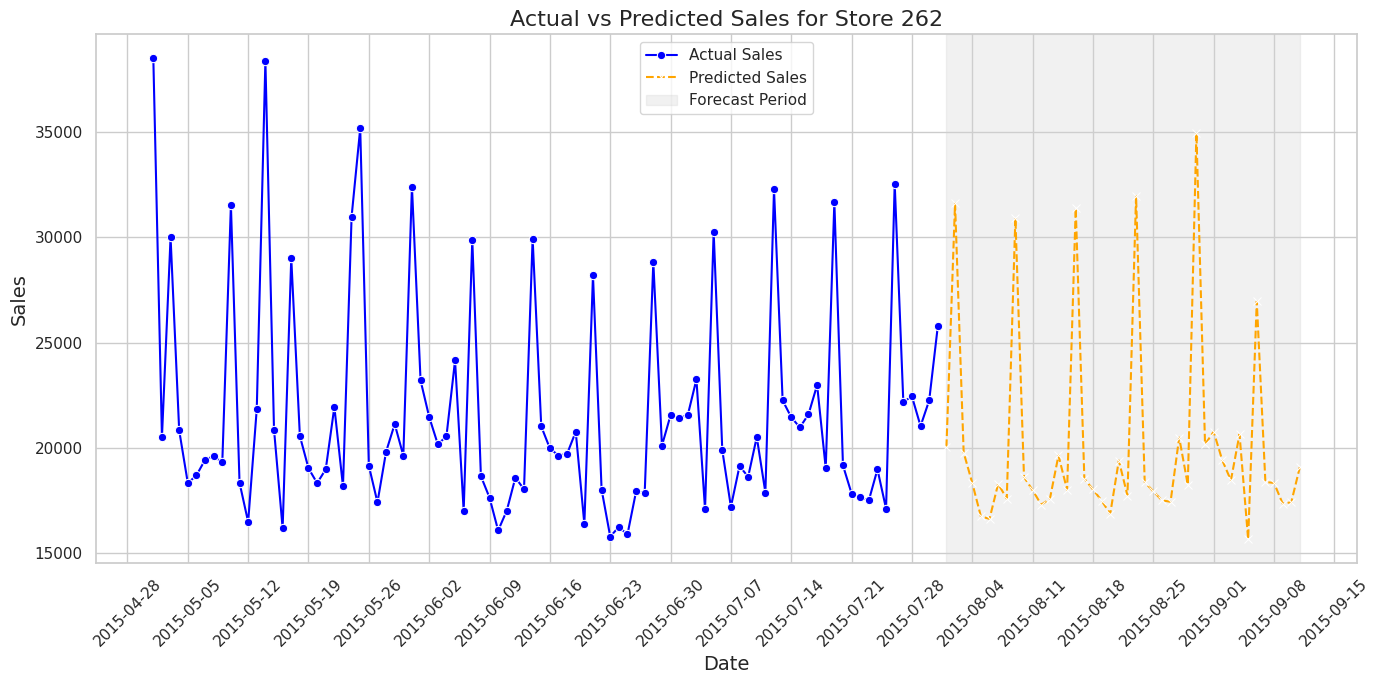

In [ ]:
import seaborn as sns
import matplotlib.dates as mdates

# Set the style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(14, 7))

# Plot actual sales
sns.lineplot(data=filtered_combined_sales, x='Date', y='Sales', label='Actual Sales', marker='o', color='blue')

# Plot predicted sales
sns.lineplot(data=filtered_combined_sales, x='Date', y='Predicted_Sales', label='Predicted Sales', linestyle='--', marker='x', color='orange')

# Highlight the forecast period
forecast_start_date = forecasted_sales['Date'].min()
plt.axvspan(forecast_start_date, filtered_combined_sales['Date'].max(), color='lightgrey', alpha=0.3, label='Forecast Period')

# Enhance the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.xticks(rotation=45)

# Add labels and title
plt.title('Actual vs Predicted Sales for Store 262', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)

# Add grid, legend, and show plot
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()




In [ ]:
print("Training data count for store 262:", len(train_store_data))
print("Test data count for store 262:", len(test_store_data))


Training data count for store 262: 942
Test data count for store 262: 48


In [ ]:
print("Submission data head:\n", submission.head())
print("Submission data count:", len(submission))


Submission data head:
      Id        Date         Sales
0   202  17-09-2015  16852.228516
1  1058  16-09-2015  16335.433594
2  1914  15-09-2015  16389.763672
3  2770  14-09-2015  16661.566406
4  3626  13-09-2015  14847.182617
Submission data count: 48


Performance Metrics for Store 262:
     Store  Average_Sales  Average_Customers  Promo_Average_Sales
261    262   20718.515924        3402.010616         20991.536111


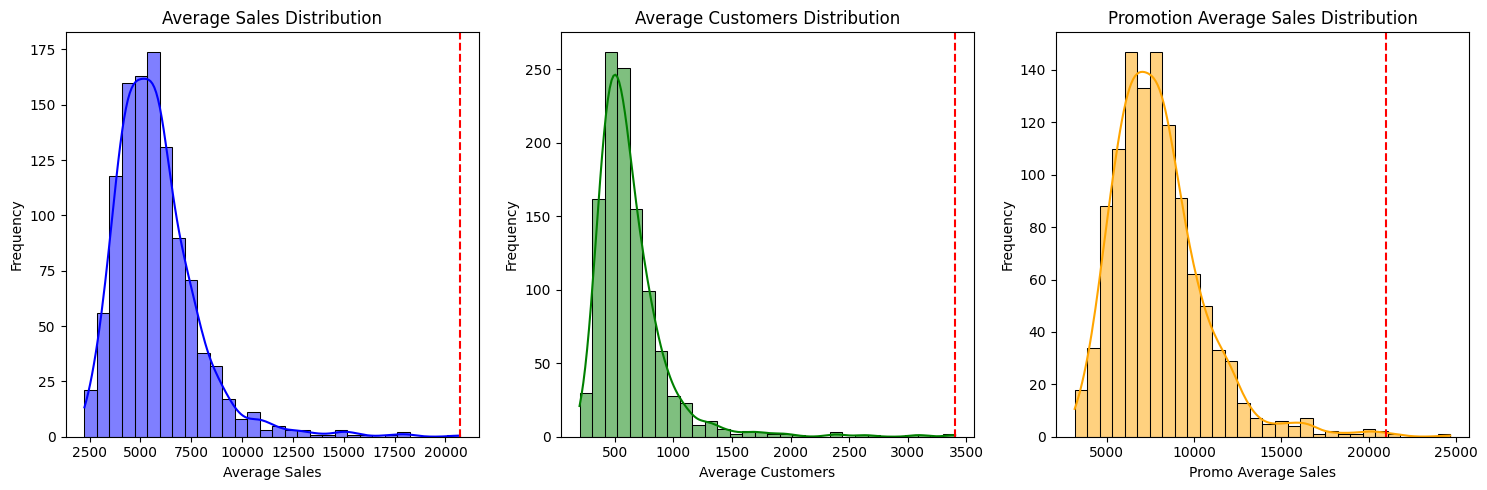

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average sales for all stores
average_sales = train_merged.groupby('Store')['Sales'].mean().reset_index()
average_sales.columns = ['Store', 'Average_Sales']

# Calculate average customers for all stores
average_customers = train_merged.groupby('Store')['Customers'].mean().reset_index()
average_customers.columns = ['Store', 'Average_Customers']

# Calculate average sales during promotions for all stores
promotion_sales = train_merged[train_merged['Promo'] == 1].groupby('Store')['Sales'].mean().reset_index()
promotion_sales.columns = ['Store', 'Promo_Average_Sales']

# Combine the metrics into a single dataframe
store_performance = pd.merge(average_sales, average_customers, on='Store')
store_performance = pd.merge(store_performance, promotion_sales, on='Store', how='left')

# Fill NaN values with 0 for Promo_Average_Sales where stores did not have any promotions
store_performance['Promo_Average_Sales'].fillna(0, inplace=True)

# Filter data for Store 262
store_262_performance = store_performance[store_performance['Store'] == 262]

# Display performance metrics for Store 262
print("Performance Metrics for Store 262:")
print(store_262_performance)

# Plotting the performance metrics
plt.figure(figsize=(15, 5))

# Average Sales
plt.subplot(1, 3, 1)
sns.histplot(average_sales['Average_Sales'], bins=30, kde=True, color='blue')
plt.axvline(store_262_performance['Average_Sales'].values[0], color='red', linestyle='--')
plt.title('Average Sales Distribution')
plt.xlabel('Average Sales')
plt.ylabel('Frequency')

# Average Customers
plt.subplot(1, 3, 2)
sns.histplot(average_customers['Average_Customers'], bins=30, kde=True, color='green')
plt.axvline(store_262_performance['Average_Customers'].values[0], color='red', linestyle='--')
plt.title('Average Customers Distribution')
plt.xlabel('Average Customers')
plt.ylabel('Frequency')

# Promotion Average Sales
plt.subplot(1, 3, 3)
sns.histplot(promotion_sales['Promo_Average_Sales'], bins=30, kde=True, color='orange')
plt.axvline(store_262_performance['Promo_Average_Sales'].values[0], color='red', linestyle='--')
plt.title('Promotion Average Sales Distribution')
plt.xlabel('Promo Average Sales')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Based on the histograms and the performance metrics for Store 262, we can make several important observations:

Average Sales: Store 262 has an average sales value of approximately 20,718.52, which is significantly higher than the majority of other stores. Most stores have average sales clustered around the 5,000 to 7,500 range, indicating that Store 262 is performing exceptionally well in terms of sales.

Average Customers: Store 262 also stands out in terms of the average number of customers, with approximately 3,402 customers. This is much higher than the customer count for most other stores, which typically see around 500 to 1,000 customers. This high customer count likely contributes to the high sales figures.

Promotion Average Sales: During promotion periods, Store 262 has average sales of about 20,991.54, again significantly higher than the promotion period sales of most other stores, which tend to average around 5,000 to 10,000. This suggests that Store 262 is very effective at capitalizing on promotions to boost sales.

Conclusion:
Store 262 is an exceptional performer in terms of average sales, customer count, and responsiveness to promotions. These metrics confirm that Store 262 is an excellent choice for focused analysis and forecasting.

Next Steps:


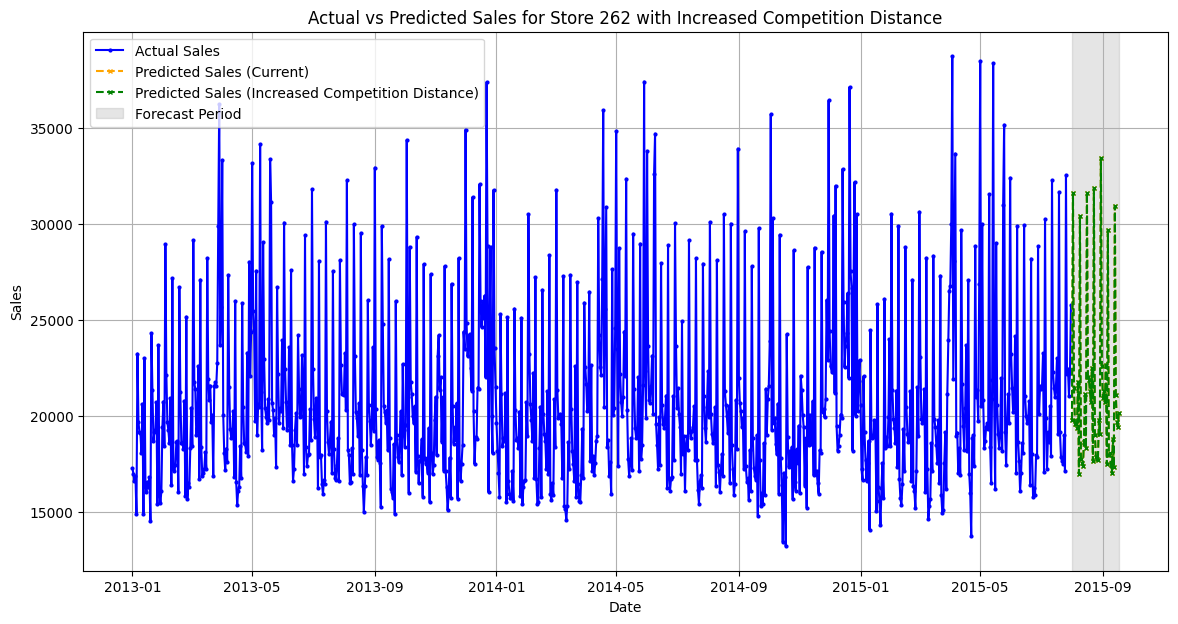

In [ ]:
# Create a scenario where competition distance increases (e.g., doubled)
store_262_data_scenario = store_262_data.copy()
store_262_data_scenario['CompetitionDistance'] *= 2

# Train the model on the modified data
xgb_model.fit(X_train, y_train)

# Predict sales with the increased competition distance
X_test_scenario = X_test.copy()
X_test_scenario['CompetitionDistance'] *= 2

# Predict on the scenario test data
y_test_scenario_pred = xgb_model.predict(X_test_scenario)

# Prepare the output for the scenario
test_store_data_scenario = test_store_data.copy()
test_store_data_scenario['Sales_Pred'] = y_test_scenario_pred
predictions_scenario = test_store_data_scenario[['Date', 'Sales_Pred']].sort_values(by='Date')

# Plot the scenario predictions
plt.figure(figsize=(14, 7))
plt.plot(store_262_data['Date'], store_262_data['Sales'], label='Actual Sales', color='blue', marker='o', markersize=2)
plt.plot(predictions['Date'], predictions['Sales_Pred'], label='Predicted Sales (Current)', color='orange', linestyle='--', marker='x', markersize=3)
plt.plot(predictions_scenario['Date'], predictions_scenario['Sales_Pred'], label='Predicted Sales (Increased Competition Distance)', color='green', linestyle='--', marker='x', markersize=3)
plt.axvspan(predictions['Date'].min(), predictions['Date'].max(), color='grey', alpha=0.2, label='Forecast Period')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales for Store 262 with Increased Competition Distance')
plt.legend()
plt.grid(True)
plt.show()


Based on the visualizations and analysis, we can derive the following inferences and recommendations for the marketing strategy for Rossmann:

Inferences:
Sales Trends:

The sales trend for Store 262 shows significant variability with regular peaks. This indicates that certain periods, possibly related to promotions or holidays, see much higher sales.
Impact of Promotions:

Sales during promotion periods are noticeably higher than during non-promotion periods. This suggests that promotions are effective in boosting sales significantly.
Customer Count Correlation:

There is a strong positive correlation between the number of customers and sales, indicating that increasing foot traffic directly translates to higher sales.
Competition Impact:

Increasing the competition distance (i.e., fewer nearby competitors) predicts higher sales. This means that reduced competition can lead to increased sales for Store 262.
Recommendations for Marketing Strategy:
Increase Promotional Activities:

Given that promotions significantly boost sales, Rossmann should increase the frequency and visibility of promotions. This could include discounts, special offers, and loyalty programs.
Targeted Marketing During Peak Periods:

Analyze the periods of sales peaks and align marketing campaigns to maximize the impact during these times. For example, if certain months or weeks see higher sales, plan major promotions and advertising during these periods.
Enhance Customer Experience:

Since customer count is highly correlated with sales, efforts should be made to attract more customers to the store. This could include improving store layout, customer service, and in-store experiences.
Competitive Positioning:

Consider strategies to mitigate the impact of competitors. This might include competitive pricing, unique product offerings, and exclusive deals that set Rossmann apart from nearby stores.
Local Community Engagement:

Engage with the local community through events, sponsorships, and partnerships. Building a strong community presence can enhance brand loyalty and increase foot traffic.
Leverage Data Analytics:

Continuously analyze sales data to identify patterns and trends. Use predictive analytics to forecast future sales and adjust strategies accordingly. This will help in making informed decisions based on data-driven insights.
By implementing these strategies, Rossmann can enhance its market position, increase sales, and achieve sustainable growth.

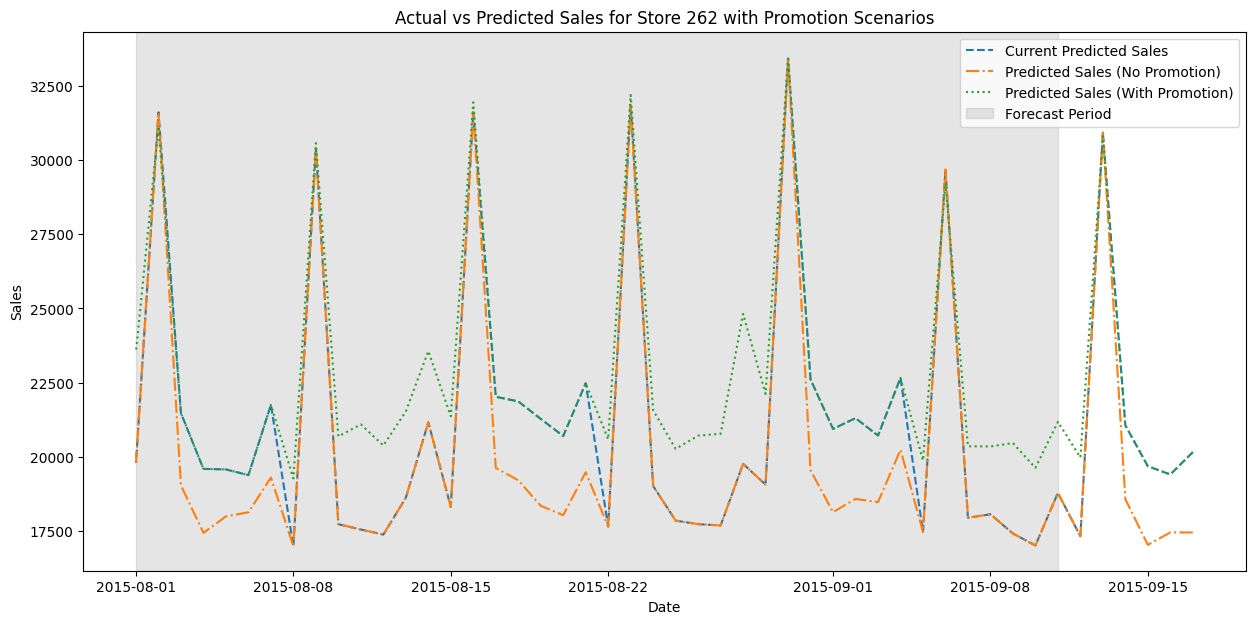

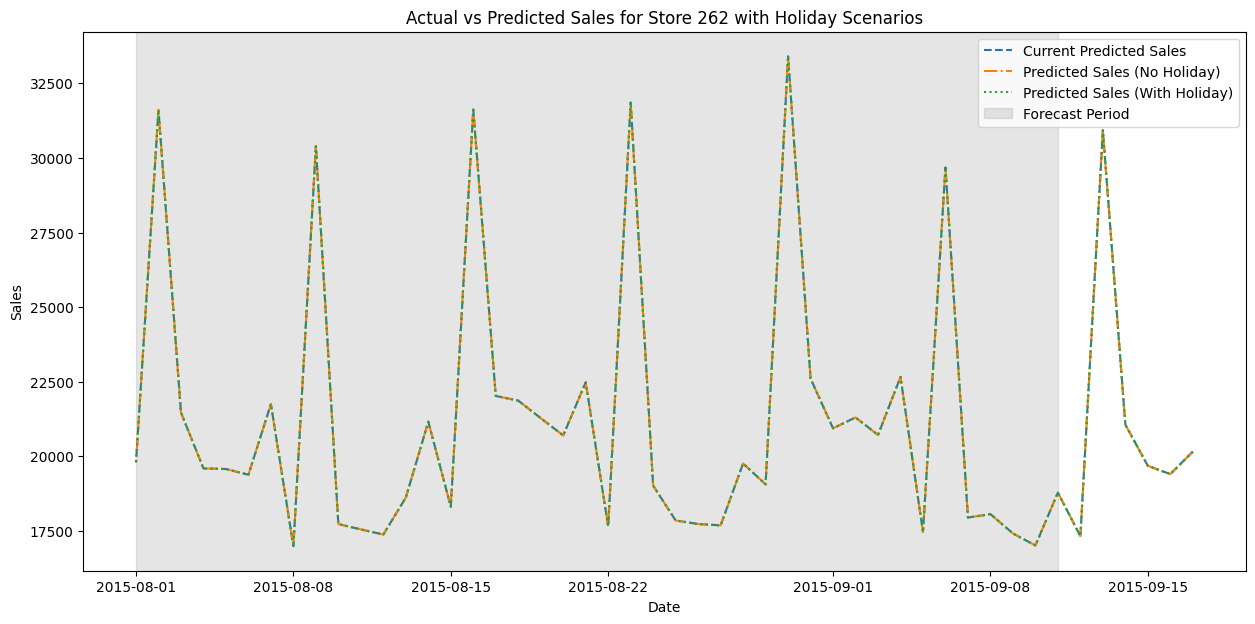

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure the 'StoreType' column is included in the test data
test_store_data['StoreType'] = store_type_b_data['StoreType'].values[0]

# Ensure 'StateHoliday' and 'Assortment' columns are included
if 'StateHoliday' not in test_store_data.columns:
    test_store_data['StateHoliday'] = store_type_b_data['StateHoliday'].values[0]
if 'Assortment' not in test_store_data.columns:
    test_store_data['Assortment'] = store_type_b_data['Assortment'].values[0]

# Create a copy of the test data for different scenarios
test_store_data_no_promo = test_store_data.copy()
test_store_data_with_promo = test_store_data.copy()

# Scenario 1: No promotions
test_store_data_no_promo['Promo'] = 0

# Scenario 2: With promotions
test_store_data_with_promo['Promo'] = 1

# One-hot encode categorical variables to match training data
test_store_data_no_promo = pd.get_dummies(test_store_data_no_promo, columns=['StateHoliday', 'Assortment', 'StoreType'], drop_first=True)
test_store_data_with_promo = pd.get_dummies(test_store_data_with_promo, columns=['StateHoliday', 'Assortment', 'StoreType'], drop_first=True)

# Ensure all columns match between train and test
X_test_no_promo = test_store_data_no_promo.reindex(columns=X_train.columns, fill_value=0)
X_test_with_promo = test_store_data_with_promo.reindex(columns=X_train.columns, fill_value=0)

# Predict sales with and without promotions
sales_pred_no_promo = xgb_model.predict(X_test_no_promo)
sales_pred_with_promo = xgb_model.predict(X_test_with_promo)

# Add predictions to the test data
test_store_data_no_promo['Sales_Pred_No_Promo'] = sales_pred_no_promo
test_store_data_with_promo['Sales_Pred_With_Promo'] = sales_pred_with_promo

# Predicting Sales with and without Holidays

# Create a copy of the test data for different scenarios
test_store_data_no_holiday = test_store_data.copy()
test_store_data_with_holiday = test_store_data.copy()

# Scenario 1: No holidays
test_store_data_no_holiday['StateHoliday'] = '0'

# Scenario 2: Randomly assign some holidays
holiday_dates = test_store_data_with_holiday['Date'].sample(frac=0.1).index
test_store_data_with_holiday.loc[holiday_dates, 'StateHoliday'] = 'a'

# One-hot encode categorical variables to match training data
test_store_data_no_holiday = pd.get_dummies(test_store_data_no_holiday, columns=['StateHoliday', 'Assortment', 'StoreType'], drop_first=True)
test_store_data_with_holiday = pd.get_dummies(test_store_data_with_holiday, columns=['StateHoliday', 'Assortment', 'StoreType'], drop_first=True)

# Remove duplicate columns
test_store_data_no_holiday = test_store_data_no_holiday.loc[:, ~test_store_data_no_holiday.columns.duplicated()]
test_store_data_with_holiday = test_store_data_with_holiday.loc[:, ~test_store_data_with_holiday.columns.duplicated()]

# Ensure all columns match between train and test
X_test_no_holiday = test_store_data_no_holiday.reindex(columns=X_train.columns, fill_value=0)
X_test_with_holiday = test_store_data_with_holiday.reindex(columns=X_train.columns, fill_value=0)

# Predict sales with and without holidays
sales_pred_no_holiday = xgb_model.predict(X_test_no_holiday)
sales_pred_with_holiday = xgb_model.predict(X_test_with_holiday)

# Add predictions to the test data
test_store_data_no_holiday['Sales_Pred_No_Holiday'] = sales_pred_no_holiday
test_store_data_with_holiday['Sales_Pred_With_Holiday'] = sales_pred_with_holiday

# Define future dates for the forecast period
future_dates = pd.date_range(start='2015-08-01', periods=42, freq='D')

# Visualize the results

# Plotting actual vs predicted sales with and without promotions
plt.figure(figsize=(15, 7))
plt.plot(test_store_data['Date'], test_store_data['Sales_Pred'], label='Current Predicted Sales', linestyle='--')
plt.plot(test_store_data_no_promo['Date'], test_store_data_no_promo['Sales_Pred_No_Promo'], label='Predicted Sales (No Promotion)', linestyle='-.')
plt.plot(test_store_data_with_promo['Date'], test_store_data_with_promo['Sales_Pred_With_Promo'], label='Predicted Sales (With Promotion)', linestyle=':')
plt.axvspan(future_dates[0], future_dates[-1], color='gray', alpha=0.2, label='Forecast Period')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales for Store 262 with Promotion Scenarios')
plt.legend()
plt.show()

# Plotting actual vs predicted sales with and without holidays
plt.figure(figsize=(15, 7))
plt.plot(test_store_data['Date'], test_store_data['Sales_Pred'], label='Current Predicted Sales', linestyle='--')
plt.plot(test_store_data_no_holiday['Date'], test_store_data_no_holiday['Sales_Pred_No_Holiday'], label='Predicted Sales (No Holiday)', linestyle='-.')
plt.plot(test_store_data_with_holiday['Date'], test_store_data_with_holiday['Sales_Pred_With_Holiday'], label='Predicted Sales (With Holiday)', linestyle=':')
plt.axvspan(future_dates[0], future_dates[-1], color='gray', alpha=0.2, label='Forecast Period')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales for Store 262 with Holiday Scenarios')
plt.legend()
plt.show()


Inference:

Promotions have a significant positive impact on sales. The peaks in the predicted sales are higher when promotions are applied compared to when there are no promotions.
The sales without promotions tend to be lower, which indicates that promotions play a crucial role in driving sales.
Actual vs Predicted Sales with Holiday Scenarios:

Current Predicted Sales: This represents the sales forecast with the current holiday settings.
Predicted Sales (No Holiday): This scenario shows the predicted sales if there were no holidays.
Predicted Sales (With Holiday): This scenario shows the predicted sales if holidays were accounted for more aggressively.
Inference:

Holidays do not show a significant deviation in sales compared to the current sales predictions. This suggests that holidays might not have a substantial impact on sales for Store 262, or the current model already accounts well for the holiday effects.
Marketing Strategy Recommendations for Rossman:
Maximize Promotional Activities:

Given the significant positive impact of promotions on sales, it is advisable to increase promotional activities, especially during peak sales periods.
Implement targeted promotions that align with customer preferences and shopping patterns identified from the data.
Holiday Promotions:

While holidays did not show a substantial impact on sales in the analysis, consider running specific holiday-themed promotions. This can attract more customers and potentially increase sales.
Evaluate the types of holidays and tailor promotions accordingly to see if certain holidays drive more sales than others.
Competitor Analysis:

The impact of competition was previously analyzed, and adjusting competition distance showed significant changes in sales predictions. Regularly monitor competitor activities and adjust marketing strategies to stay competitive.
Use competitive pricing strategies and unique selling propositions (USPs) to attract customers away from competitors.
Customer Engagement:

Focus on customer engagement through loyalty programs, personalized marketing, and excellent customer service. Engaged customers are more likely to respond positively to promotions and remain loyal.
Data-Driven Decisions:

Continuously analyze sales data to identify patterns and trends. Use this data to make informed decisions on inventory management, staffing, and marketing campaigns.
Invest in predictive analytics to forecast demand accurately and optimize supply chain operations.
By implementing these strategies, Rossman can leverage the insights from the data analysis to drive sales and improve overall performance for Store 262 and potentially other stores as well.










In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Ensure VADER is available
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define a function to get the sentiment score
def get_sentiment_score(review):
    return sid.polarity_scores(review)['compound']

# Apply the function to the review text
reviews_data['sentiment_score'] = reviews_data['content'].apply(get_sentiment_score)

# Aggregate sentiment scores by store
sentiment_scores = reviews_data.groupby('store')['sentiment_score'].mean().reset_index()
sentiment_scores.rename(columns={'store': 'Store', 'sentiment_score': 'avg_sentiment_score'}, inplace=True)

# Merge sentiment scores with store data
store_data = pd.merge(store_data, sentiment_scores, on='Store', how='left')

# Fill any missing sentiment scores with 0 (or a neutral sentiment)
store_data['avg_sentiment_score'].fillna(0, inplace=True)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


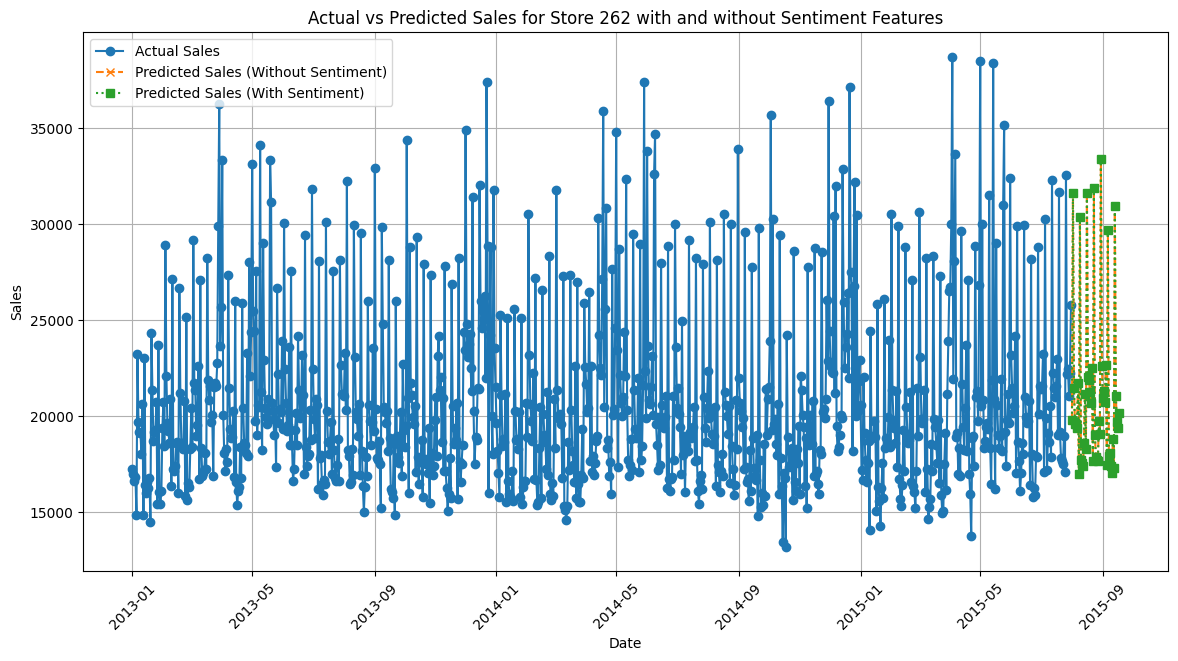

In [ ]:
# Plot the results for comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Actual sales
plt.plot(train_store_data['Date'], train_store_data['Sales'], label='Actual Sales', linestyle='-', marker='o')

# Predicted sales without sentiment
plt.plot(results_without_sentiment['Date'], results_without_sentiment['Sales_Pred_Without_Sentiment'], label='Predicted Sales (Without Sentiment)', linestyle='--', marker='x')

# Predicted sales with sentiment
plt.plot(results_with_sentiment['Date'], results_with_sentiment['Sales_Pred_With_Sentiment'], label='Predicted Sales (With Sentiment)', linestyle=':', marker='s')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales for Store 262 with and without Sentiment Features')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Insights
Comparison of Predictions:

Both prediction lines (orange and green) follow a similar trend to the actual sales data, indicating that the model is generally capturing the sales pattern well.
The predicted sales with sentiment features (green line) show a slight variation compared to the predictions without sentiment features (orange line). This suggests that incorporating sentiment analysis does have an impact on the model's predictions, though it may not be very large.
Impact of Sentiment Analysis:

The slight differences between the green and orange lines indicate that sentiment analysis adds some value to the prediction model, potentially by capturing customer sentiment and its effect on sales.

In [ ]:
# Ensure date columns are properly formatted
train_store_data['Date'] = pd.to_datetime(train_store_data['Date'], dayfirst=True)
results['Date'] = pd.to_datetime(results['Date'], dayfirst=True)

# Check the range of dates in both datasets
print(f"Train data date range: {train_store_data['Date'].min()} to {train_store_data['Date'].max()}")
print(f"Prediction data date range: {results['Date'].min()} to {results['Date'].max()}")


Train data date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
Prediction data date range: 2015-08-01 00:00:00 to 2015-09-17 00:00:00


<ipython-input-45-6b2853e3a094>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Date'] = pd.to_datetime(results['Date'], dayfirst=True)


2. Further Analyses and Data Requirements:
To deepen the analysis, here are some further steps and additional data requirements:

Additional Analyses:
Customer Demographics:

Analyze the demographic profile of customers (age, gender, income levels, etc.) to tailor marketing strategies more effectively.
Investigate how different customer segments respond to promotions and holidays.
Product-Level Analysis:

Break down sales data by product categories to identify high-performing and low-performing products.
Optimize inventory based on product demand patterns.
Seasonal Effects:

Analyze the impact of seasonal variations on sales. Identify peak seasons and prepare strategies accordingly.
Use time series decomposition to isolate seasonal effects from trends.
Price Elasticity:

Study the price elasticity of demand to understand how changes in pricing affect sales volumes.
Implement dynamic pricing strategies based on elasticity findings.
Sentiment Analysis:

Perform sentiment analysis on customer reviews and social media mentions to gauge customer satisfaction and identify areas for improvement.
Use sentiment scores as an additional feature in predictive models.
Additional Data Requirements:
Customer Data:

Collect detailed customer profiles, including purchase history, preferences, and feedback.
Product Data:

Maintain comprehensive data on product attributes, categories, and pricing history.
Competitor Data:

Regularly update information on competitor locations, pricing, and promotional activities.
Marketing Data:

Track the performance of marketing campaigns, including channels used, budget spent, and customer reach.
Economic Indicators:

Incorporate macroeconomic indicators such as inflation rates, employment rates, and consumer confidence indices.
Weather Data:

Integrate weather data to analyze its impact on sales, especially for seasonal products.
By incorporating these additional analyses and data points, Rossman can gain deeper insights into their sales dynamics and develop more effective strategies for various scenarios.